In [14]:
import numpy as np
import matplotlib.pyplot as plt
from pyuvdata import UVBeam
import glob
from pygsm import GlobalSkyModel
import healpy as hp
import copy

In [8]:
uvb = UVBeam()
beamfiles = sorted(glob.glob('/home/aaronew/science/CST/single_vivaldi_stripped_down/Export/Farfield/*.txt'))
beamfiles = beamfiles[-50:] + beamfiles[:-50]
beamfiles=beamfiles[:-1]

201


In [118]:
beamfiles[-1]
beamfiles[-2]

'/home/aaronew/science/CST/single_vivaldi_stripped_down/Export/Farfield/farfield (f=248) [1].txt'

In [19]:
dTb = np.load('models_21cm.npz')['models']
freqs = np.load('models_21cm.npz')['freqs']

In [21]:
uvb.read_cst_beam(beamfiles, rotate_pol=True, telescope_name='HERA',
                  feed_name='Vivaldi', feed_version='v0', model_name='barebones', model_version='v0',
                  history='null', x_orientation='north', reference_impedance=100,
                  frequency=freqs)

In [22]:
uvb.interpolation_function='az_za_simple'

In [23]:
uvb_not_interpolated=copy.deepcopy(uvb)
uvb.to_healpix(nside=64)

Load up GSM

In [16]:
nside = 64
gsmcube = np.zeros((200, hp.nside2npix(nside)))

In [25]:
mygsm = GlobalSkyModel(freq_unit='GHz')
for chan,f in enumerate(freqs):
    gsmcube[chan] = hp.ud_grade(mygsm.generate(f), nside_out=nside)

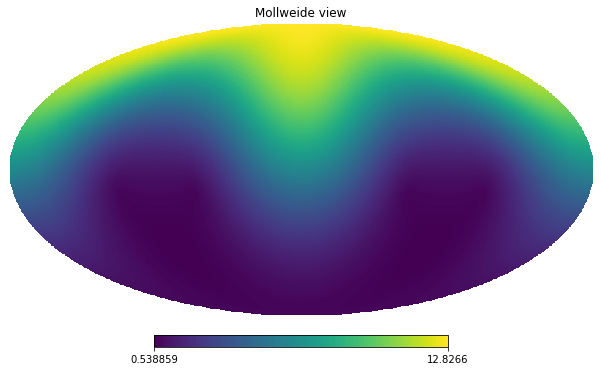

In [28]:
rot2 = hp.Rotator(rot=[0, 0, 0])
rot1 = hp.Rotator(rot=[0, 90, 0])
hp.mollview(rot2.rotate_map_pixel(\
            rot1.rotate_map_pixel(uvb.data_array[0,0,0,0,:])))

Rotat beam to az el coords.

(190.0, 200.0)

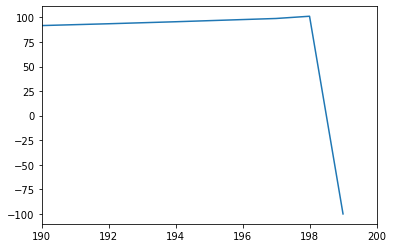

In [119]:
plt.plot(uvb.data_array[0,0,0,:,0])
plt.xlim(190,200)

In [32]:
for pol in range(uvb.Npols):
    uvb.data_array[0,0,pol,:,:] = np.asarray(hp.Rotator(rot=[0, 90, 0]).rotate_map_pixel(uvb.data_array[0,0,pol,:,:].squeeze()))

You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


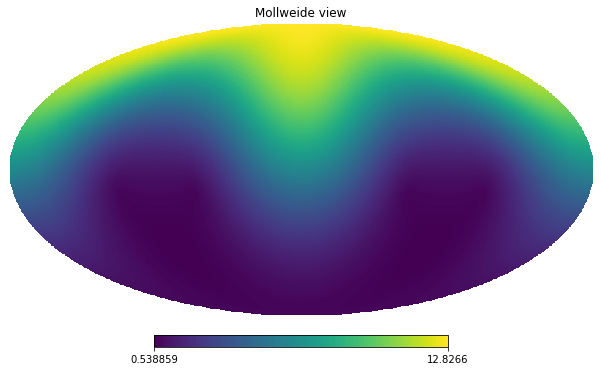

In [33]:
hp.mollview(uvb.data_array[0,0,0,0,:])

In [40]:
thetas, phis = hp.pix2ang(nside, range(gsmcube.shape[1]))
lsts=np.arange(360)
NLST = len(lsts)
NF = len(freqs)
rot_lat = hp.Rotator(rot=[0, 30, 0])
rot_gc = hp.Rotator(coord=['G', 'C'])
gsm_gc = np.asarray(rot_gc.rotate_map_pixel(gsmcube))#rotate from galactic to celestial.
lsts = np.linspace(0, 360, NLST)
waterfall = np.zeros((NLST, NF))
for integ, lst in enumerate(lsts):
    rot_lst = hp.Rotator(rot=[lst, 0, 0])
    gsm_alt_az = np.asarray(rot_lat.rotate_map_pixel(rot_lst.rotate_map_pixel(gsm_gc))) # rotate from Celestial to alt-az
    gsm_alt_az[:, thetas>=np.pi/2.] = 300. # set earth temperature
    waterfall[integ] = np.sum(gsm_alt_az * uvb.data_array[0,0,0,:,:], axis=1)
    
    

In [98]:
norm =  np.mean(np.sum(uvb.data_array[0,0,0,:,:], axis=1))

In [99]:
np.savez('waterfall.npz', data=waterfall / norm, freqs=freqs, lsts=lsts)

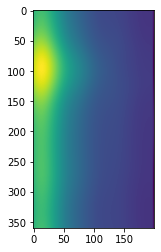

In [100]:
plt.imshow(waterfall)

In [129]:
cov_wf = np.cov(waterfall[:,:-2].T / norm ** 2.)

In [130]:
evals, evecs = np.linalg.eig(cov_wf)

Casting complex values to real discards the imaginary part


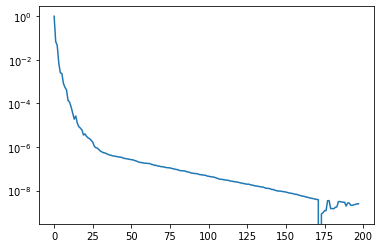

In [131]:
plt.plot(np.sqrt(evals / evals.max()))
plt.yscale('log')

Casting complex values to real discards the imaginary part
Casting complex values to real discards the imaginary part


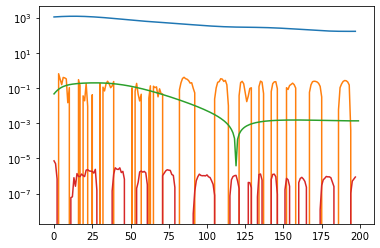

In [132]:
plt.plot(waterfall[0,:-2] /norm)
plt.plot(waterfall[0, :-2]/norm - (evecs[:, :25] @ evecs[:, :25].T) @ waterfall[0, :-2] / norm)
plt.yscale('log')
plt.plot(np.abs(dTb[0] * 1e-3))
plt.plot(dTb[0, :-2]/norm - (evecs[:, :25] @ evecs[:, :25].T) @ dTb[0, :-2] / norm)

In [133]:
plt.plot(evecs.T @ dTb[0])
plt.plot(evecs.T @ waterfall[0])
plt.yscale('log')

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 200 is different from 198)